<a href="https://colab.research.google.com/github/Angel-dash/Abstractive-Text-Summarization/blob/main/Copy_of_DL_og.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Uncomment the code below if you are running on google colab
If you are running the code on the google colab then you must have the data set on your google drive. Link to the dataset where you can download it form https://drive.google.com/file/d/1CAK0Cj1kNgoZ0FRxwwCflbh-1-hKDPoK/view?usp=sharing



In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)


Mounted at /content/drive


In [2]:
#!unzip /content/drive/MyDrive/DL/data.zip # Comment out for niranjan's
!unzip /content/drive/MyDrive/MiniProjectdata/data.zip #comment out for Angel's



Archive:  /content/drive/MyDrive/MiniProjectdata/data.zip
replace cnn_dailymail/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: cnn_dailymail/test.csv  
replace cnn_dailymail/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: cnn_dailymail/train.csv  y
y
y
y

replace cnn_dailymail/validation.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: cnn_dailymail/validation.csv  


In [3]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
import textwrap
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
data_train=pd.read_csv('/content/cnn_dailymail/train.csv')
#data_test=pd.read_csv('/content/cnn_dailymail/test.csv')
#data_validation=pd.read_csv('/content/cnn_dailymail/validation.csv')
#data=pd.read_csv('/content/Reviews.csv',nrows=100000)

Data preprocessing

In [5]:
#data = pd.concat([data_train, data_test, data_validation ])
df = data_train

In [6]:
new_df=df.sample(5000)

In [7]:
new_df.head(3)

,id,article,highlights
80318,e3ac5e857b7b02bf68fb9cd3e105a9767c69f8a9,Gone are the days when a pair of black Copa Mundials were the boot of choice for England players ahead of the World Cup. Today's stars prefer to be noticed on the pitch and it seems the more fluor...,Raheem Sterling wore Nike's new Flyknit Mercurial Superfly IV boot at Wembley on Friday .\nReplaced Wayne Rooney during England's 3-0 win over Peru .\nBoot was unveiled by Cristiano Ronaldo last m...
126393,2f58cd2418f692816907b095f52188f522e316c0,"Barack Obama could become the latest in a short list of impeached U.S. presidents, according to Sen. Jim Inhofe and Daily Beast columnist Michael Tomasky . The specter of impeachment proceedings a...","Sen. Jim Inhofe: 'People may be starting to use the ""I""-word before too long'\nDaily Beast columnist Michael Tomasky: Benghazi 'a potential impeachment issue as long as the Republicans are in cont..."
88036,f9d5ba597d9907c98d3522e002134b8d1704cbca,"The only lifeline one tiny, isolated Alaskan island has to the rest of the world is cut off, leaving snowed-in residents deprived of any food, mail or deliveries of any kind. The single helicopter...","Little Diomede, population 100, has seen its cupboards running empty since January when its only helicopter was grounded for maintenance .\nCold hardy residents have even been largely unable to b..."


In [8]:
new_df.shape

(5000, 3)

In [9]:
#sample=new_df.sample()
#print("****Article****")
#print(sample.article.values)
#print('****Highlights****')
#print(sample.highlights.values)

Checking for Null values


In [9]:
new_df.isna().sum()

id            0
article       0
highlights    0
dtype: int64

Checking for duplicates


In [10]:
new_df.duplicated(subset=['article']).sum()

0

In [11]:
new_df=new_df.drop_duplicates(subset=['article'])
new_df.shape

(5000, 3)

In [12]:
new_df.duplicated(subset=['article']).sum()

0

In [13]:
new_df['article'][:10]

80318     Gone are the days when a pair of black Copa Mundials were the boot of choice for England players ahead of the World Cup. Today's stars prefer to be noticed on the pitch and it seems the more fluor...
126393    Barack Obama could become the latest in a short list of impeached U.S. presidents, according to Sen. Jim Inhofe and Daily Beast columnist Michael Tomasky . The specter of impeachment proceedings a...
88036     The only lifeline one tiny, isolated Alaskan island has to the rest of the world is cut off, leaving snowed-in residents deprived of any food, mail or deliveries of any kind. The single helicopter...
260940    By . David Williams . and Nick Fagge In Gyor, Hungary . Straddling a powerful motorbike in his leathers, this is the first picture of the ex-Hungarian policeman named as a suspect in the brutal mu...
125750    (CNN) -- The number of bird flu cases in China jumped Sunday to 102, including 20 deaths, the World Health Organization announced. Seventy patients re

In [14]:
new_df['article'] = new_df['article'].str.lower()
new_df['highlights'] = new_df['highlights'].str.lower()

new_df.head()

,id,article,highlights
80318,e3ac5e857b7b02bf68fb9cd3e105a9767c69f8a9,gone are the days when a pair of black copa mundials were the boot of choice for england players ahead of the world cup. today's stars prefer to be noticed on the pitch and it seems the more fluor...,raheem sterling wore nike's new flyknit mercurial superfly iv boot at wembley on friday .\nreplaced wayne rooney during england's 3-0 win over peru .\nboot was unveiled by cristiano ronaldo last m...
126393,2f58cd2418f692816907b095f52188f522e316c0,"barack obama could become the latest in a short list of impeached u.s. presidents, according to sen. jim inhofe and daily beast columnist michael tomasky . the specter of impeachment proceedings a...","sen. jim inhofe: 'people may be starting to use the ""i""-word before too long'\ndaily beast columnist michael tomasky: benghazi 'a potential impeachment issue as long as the republicans are in cont..."
88036,f9d5ba597d9907c98d3522e002134b8d1704cbca,"the only lifeline one tiny, isolated alaskan island has to the rest of the world is cut off, leaving snowed-in residents deprived of any food, mail or deliveries of any kind. the single helicopter...","little diomede, population 100, has seen its cupboards running empty since january when its only helicopter was grounded for maintenance .\ncold hardy residents have even been largely unable to b..."
260940,ddf3f6cb699ab5186d2543c46cedc2a651242c9c,"by . david williams . and nick fagge in gyor, hungary . straddling a powerful motorbike in his leathers, this is the first picture of the ex-hungarian policeman named as a suspect in the brutal mu...","eva rhodes found dead in 2008 at the animal sanctuary she ran .\ncaretaker csaba augusztinyi, 33, confessed and was jailed for 13 years .\nfamily believe others were involved in the brutal killing..."
125750,2e8c21c7fdf395fabbd6d522dc53aa95ef2f1c75,"(cnn) -- the number of bird flu cases in china jumped sunday to 102, including 20 deaths, the world health organization announced. seventy patients remain hospitalized with the virus. the who said...","the cases include 20 deaths, and 102 infection cases .\nseventy patients are hospitalized with the virus .\nthe new strain wasn't known until three weeks ago .\ninternational experts in china to m..."


In [15]:
#removing html tags
import re
def remove_html_tags(text):
    if isinstance(text, str):
        pattern = re.compile('<.*?>')
        return pattern.sub(r'', text)
    else:
        return text

Converting to lower case

In [16]:
new_df['article'] = new_df['article'].apply(remove_html_tags)

new_df['highlights'] = new_df['highlights'].apply(remove_html_tags)

In [17]:
#removing punchuation


import string
string.punctuation
exclude = string.punctuation
def remove_punc(text):
    if isinstance(text, str):
        return ''.join(ch for ch in text if ch not in exclude)
    else:
        return str(text)  # Convert non-string data to string

In [18]:
new_df['article'] = new_df['article'].apply(remove_punc)

new_df['highlights'] = new_df['highlights'].apply(remove_punc)

In [19]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
new_df['article'] = new_df['article'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
new_df['highlights'] = new_df['highlights'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
new_df.head(1)

,id,article,highlights
80318,e3ac5e857b7b02bf68fb9cd3e105a9767c69f8a9,gone days pair black copa mundials boot choice england players ahead world cup todays stars prefer noticed pitch seems fluorescent boot better whole host bright colours seen flashing across wemble...,raheem sterling wore nikes new flyknit mercurial superfly iv boot wembley friday replaced wayne rooney englands 30 win peru boot unveiled cristiano ronaldo last month host stars wear boot next mon...


In [22]:
#!pip install contractions
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [23]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
#call the function
cleaned_text = []
for t in df['article']:
    cleaned_text.append(text_cleaner(t,0))

In [57]:
cleaned_text[:5]

array(['associated press published est october updated est october bishop fargo catholic diocese north dakota exposed potentially hundreds church members fargo grand forks jamestown hepatitis virus late september early october state health department issued advisory exposure anyone attended five churches took communion bishop john folda fargo catholic diocese north dakota exposed potentially hundreds church members fargo grand forks jamestown hepatitis state immunization program manager molly howell says risk low officials feel important alert people possible exposure diocese announced monday bishop john folda taking time diagnosed hepatitis diocese says contracted infection contaminated food attending conference newly ordained bishops italy last month symptoms hepatitis include fever tiredness loss appetite nausea abdominal discomfort fargo catholic diocese north dakota bishop located',
       'ralph mata internal affairs lieutenant miami dade police department working division invest

In [25]:
df['highlights'] = df['highlights'].astype(str)

In [26]:
#call the function
cleaned_summary = []
for t in df['highlights']:
    cleaned_summary.append(text_cleaner(t,1))

In [27]:
cleaned_summary[:10]

['bishop john folda of north dakota is taking time off after being diagnosed he contracted the infection through contaminated food in italy church members in fargo grand forks and jamestown could have been exposed',
 'criminal complaint cop used his role to help cocaine traffickers ralph mata an internal affairs lieutenant allegedly helped group get guns he also arranged to pay two assassins in murder plot complaint alleges',
 'craig eccleston todd had drunk at least three pints before driving car was using phone when he veered across road in yarmouth isle of wight crashed head on into year old rachel titley car who died in hospital police say he would have been over legal drink drive limit at time of crash he was found guilty at portsmouth crown court of causing death by dangerous driving',
 'nina dos santos says europe must be ready to accept sanctions will hurt both sides targeting russia business community would be one way of sapping their support for president putin she says but s

In [28]:
df['cleaned_text']=cleaned_text
df['cleaned_summary']=cleaned_summary

In [29]:
df.replace('', np.nan, inplace=True)
df.dropna(axis=0,inplace=True)

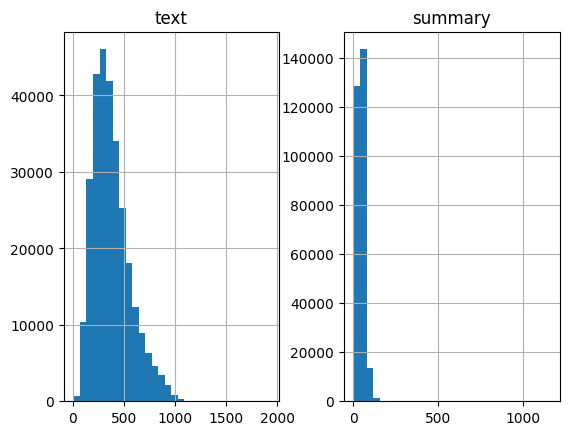

In [30]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in df['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [31]:
max_len_text=300
max_len_summary=100

In [32]:
cnt=0
for i in df['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print(cnt/len(df['cleaned_summary']))

0.0013130718567254008


In [33]:
cleaned_text =np.array(df['cleaned_text'])
cleaned_summary=np.array(df['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_len_summary and len(cleaned_text[i].split())<=max_len_text):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [34]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [35]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

In [36]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [37]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 54.332160786858374
Total Coverage of rare words: 0.7853636538064972


In [38]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_len_text, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_len_text, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1


In [39]:
x_voc

93605

In [40]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

Reducing the x_voc_size could help us to remove the number of parameters in the embedding layers.
Taking the threshold of the rare words can help us remvoe the number of parameters.
Else we have to change the dataset to something smaller

In [41]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 70.06453804347827
Total Coverage of rare words: 2.5886158397403003


End of the tokenization method for x and begining of the tokenization of y
for y only one method is used so far and based on the performance of the x tokenization. One of the method is used.

In [42]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_len_summary, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [43]:
y_voc

26440

In [44]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(101049, 101049)

In [45]:
type(y_tr)

numpy.ndarray

In [46]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [47]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [59]:
from keras import backend as K
K.clear_session()
latent_dim = 16
embedding_dim=32 #Keeping latent dimension to 300 and introducing embedding dimension of 100 to reduce the number of parameters of the model
#condider chaging the latent_dim to smaller value such as 100 or 300
#also adding a seperate embedding_dim can help to reduce the compleixity of the model

Using word2vec

In [94]:
#Creating a single shared embedding
#shared_emb_layer = Embedding(max(x_voc, y_voc), embedding_dim, trainable=True)


In [60]:
#encoder
encoder_inputs = Input(shape=(max_len_text,))
enc_emb = Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)
#enc_emb = shared_emb_layer(encoder_inputs)

In [61]:
#LSTM 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.5,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#LSTM2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.5,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

'''encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)'''

'encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)\nencoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)'

In [62]:
#decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)
#dec_emb = shared_emb_layer(decoder_inputs)

In [63]:
#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h2, state_c2])


In [64]:
#pip install attention_keras
import tensorflow as tf
from tensorflow.python.keras import backend as K

logger = tf.get_logger()

class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs,verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [65]:
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_output2, decoder_outputs])

In [66]:
# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

In [67]:
#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

In [68]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 300, 32)              2995360   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 300, 16),            3136      ['embedding[0][0]']           
                              (None, 16),                                                     

In [69]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [70]:
#using Early stoppage to stop the training of the model once the validation increasers

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
history=model.fit(
    [x_tr,y_tr[:,:-1]],
    y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,
    epochs=20,callbacks=[es],
    batch_size=256, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Epoch 1/20
182/395 [============>.................] - ETA: 13:06 - loss: 7.3283

In [ ]:
'''history=model.fit(
    [x_tr,y_tr[:,:-1]],
    y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:]
    ,epochs=20,callbacks=[es],
    batch_size=256,
    validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))'''

In [ ]:
print("Training accuracy:", history.history["accuracy"][-1])
print("Validation accuracy:", history.history["val_accuracy"][-1])


Training accuracy: 0.7440202832221985
Validation accuracy: 0.7210544943809509


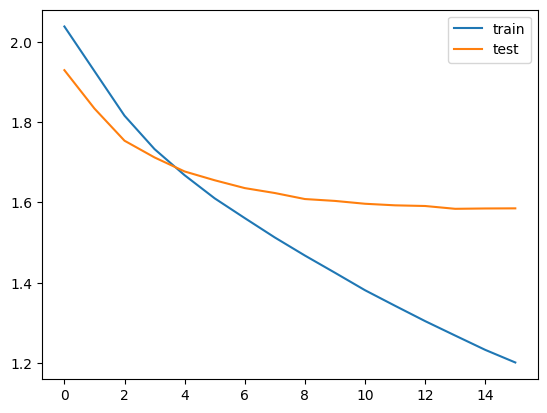

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_output2, state_h2, state_c2])

In [ ]:
# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

In [ ]:
# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

In [ ]:
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])



In [ ]:
#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

In [ ]:
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

In [ ]:
# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: purchased favorite grandson difficult find glad amazon offers able get large selection packages flavors rich flavor little high calorie good issue 
Original summary: white chocolate mix 
1/1 [==============================] - 0s 19ms/step
Predicted summary:  great taste


Review: firm believer nescafe best available instant decided try like coffee strong need lot stuff classic bad nescafe better 
Original summary: stick to 
1/1 [==============================] - 0s 21ms/step
Predicted summary:  great taste


Review: hot chocolate really delicious use two spoons milk couple spoons sugar natural sweetener tastes great drink two mugs every day service really great ordered sunday delivered monday complaints 
Original summary: navitas is good 
1/1 [==============================] - 0s 19ms/step
Predicted summary:  great hot chocolate


Review: expected get paid cookies soooooo good care much 
Original summary: yummie 
1/1 [==============================] - 0s 21ms/step
Predicted sum